In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
from scipy.stats import norm

Populating the interactive namespace from numpy and matplotlib


/Users/saurabhsood/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


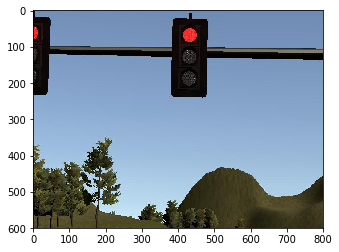

In [ ]:
########## THIS SECTION IS FOR DISPLAYING OUTPUT IMAGES ##########
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image

def display_image(img_path, box_coords=None):
    im = np.array(Image.open(img_path), dtype=np.uint8)
    
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    if box_coords is not None:
        #[[ 222.87913513   36.54263306  365.14932251  102.00504303]
        # [ 229.9644165   322.65756226  379.26095581  383.2744751 ]]
        # Create a Rectangle patch
        ## Coordinates are in order - top, left, bot, right
        for idx, box in enumerate(box_coords):
            #print("idx=",idx, " box=", box)
            rect_width = box[3]-box[1]
            rect_height = box[2]-box[0]
            rect = patches.Rectangle((box[1],box[0]),rect_width,rect_height,linewidth=1,edgecolor='r',facecolor='none')
            #rect = patches.Rectangle((50,100),40,30,linewidth=1,edgecolor='r',facecolor='none')
            # Add the patch to the Axes
            ax.add_patch(rect)
    plt.show()
    
display_image('images/left0036.jpg')

## Coordinates are in order - top, left, bot, right
image_36_box_coords_test = [[25.54330254,383.93304443,244.43661499,480.30871582]]
display_image('images/left0036.jpg', image_36_box_coords_test)

In [ ]:
SSD_GRAPH_FILE = '../../../frozen_model/ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb'
confidence_cutoff = 0.3  # confidence to detect object and edge
padx = 10   # the padding from the boundary 
pady = 10   # the padding from the boundary 
red_green_contrast = 1.8 # if red color is 1.8 times more than green color in the bounding box, treat as red light.
type_traffic_light = 10.0 # seems class 10.0 is for traffic light like thing

In [ ]:
def filter_boxes(min_score, boxes, scores, classes):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score:
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].
    
    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

        
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

In [ ]:
detection_graph = load_graph(SSD_GRAPH_FILE)
# detection_graph = load_graph(RFCN_GRAPH_FILE)
# detection_graph = load_graph(FASTER_RCNN_GRAPH_FILE)

# The input placeholder for the image.
# `get_tensor_by_name` returns the Tensor with the associated name in the Graph.
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Each box represents a part of the image where a particular object was detected.
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represent how level of confidence for each of the objects.
# Score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')

# The classification of the object (integer id).
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

In [ ]:
def detect_red_light(image_file):
    image = Image.open(image_file)
    

    image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)

    with tf.Session(graph=detection_graph) as sess:                
        # Actual detection.
        (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                            feed_dict={image_tensor: image_np})

        # Remove unnecessary dimensions
        boxes = np.squeeze(boxes)
        scores = np.squeeze(scores)
        classes = np.squeeze(classes)


        # Filter boxes with a confidence score less than `confidence_cutoff`
        boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

        # The current box coordinates are normalized to a range between 0 and 1.
        # This converts the coordinates actual location on the image.
        width, height = image.size
        box_coords = to_image_coords(boxes, height, width)
    
    ### DISPLAYING IMAGE WITH BOXES JUST FOR DEBUGGING
    #print(box_coords)
    display_image(image_file, box_coords)
    ##################
    
    # compare the red color with green color
    pix = image.load()
    contains_red_light = False
    for i in range(len(box_coords)):
        if classes[i] == type_traffic_light: 
            top, left, bot, right = box_coords[i, ...]
            r, g, b = 0, 0, 0

            for x in range(int(left) + padx, int(right) - padx):
                for y in range(int(top) + pady, int(bot) - pady):
                    p = pix[x, y]
                    r = r + p[0]
                    g = g + p[1]
                    b = b + p[2]

            if (g == 0 and r > 10000) or r / g > red_green_contrast:
                return True
    
    return False

In [ ]:
detect_red_light("images/left0606.jpg")

In [ ]:
import os
for file in os.listdir("images"):
    if file.endswith(".jpg"):
        file_path = os.path.join("images", file)
        #display_image(file_path)
        contains_red = detect_red_light(file_path)
        print("   ", file_path)
        print("    Contains red light? ", contains_red)
        print("------------------------------------------")